# 青空文庫から感情曲線取得

In [1]:
import os
import pandas as pd
import numpy as np
from tqdm.notebook import tqdm
from zipfile import ZipFile
from pathlib import Path
import time
import urllib.error
import urllib.request
import japanize_matplotlib
import matplotlib.pyplot as plt

In [2]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from transformers import pipeline
import torch
import torch.nn.functional as F

In [3]:
# GPUが使用できるか確認
if torch.cuda.is_available():
    print('gpu is available')
else:
    raise Exception('gpu is NOT available')

gpu is available


In [4]:
# モデルやトークナイザーの名称を定義
TOKENIZER_NAME = 'A-Funakoshi/bert-base-japanese-v3-wrime-sentiment'
MODEL_NAME = 'A-Funakoshi/bert-base-japanese-v3-wrime-sentiment'
# TOKENIZER_NAME = 'A-Funakoshi/sample-text-classification-bert'
# MODEL_NAME = 'A-Funakoshi/sample-text-classification-bert'
# TOKENIZER_NAME = 'koheiduck/bert-japanese-finetuned-sentiment'
# MODEL_NAME = 'koheiduck/bert-japanese-finetuned-sentiment'
# SCORE_FOLDER = MODEL_NAME.replace('/', '_')
SCORE_FOLDER = 'bert-base-japanese-v3-wrime-sentiment'

TOKENIZER_NAME, MODEL_NAME, SCORE_FOLDER

('A-Funakoshi/bert-base-japanese-v3-wrime-sentiment',
 'A-Funakoshi/bert-base-japanese-v3-wrime-sentiment',
 'bert-base-japanese-v3-wrime-sentiment')

In [5]:
# 保存用のフォルダがなければ作成
if os.path.isdir(f'data/{SCORE_FOLDER}'):
    print('savel folder exists.')
else:
    print('make save folder.')
    os.makedirs(f'data/{SCORE_FOLDER}')

make save folder.


## 関数定義

In [6]:
# 必要な特徴量のみ選択
def select_features(df_all):
    # 氏名，かな
    df_kanji = df_all['姓'] + ' ' + df_all['名']
    df_kana = df_all['姓読み'] + ' ' + df_all['名読み']
    df_name = pd.concat([df_all['人物ID'], df_kanji, df_kana], axis=1).rename(columns={0: '氏名', 1: '読み'})
    # 作品名
    df_work = df_all.loc[:, ['作品ID', '作品名', '副題', '作品名読み']]
    # URL
    df_url = df_all.loc[:, ['図書カードURL', 'テキストファイルURL']]
    # 結合
    df = pd.concat([df_name, df_work, df_url], axis=1)
    df = df.reset_index().drop(['index'], axis=1) # index振り直し
    df.insert(0, '対象', True) # 対象列の追加
    df['テキストファイルパス'] = '' # 保存場所
    df['備考'] = ''
    return df

In [7]:
# クレンジングされたデータを保存する
def save_text(target_file, org_dir, file_name, sep=',', force=False):
    try:
        save_file = f'{org_dir}/{file_name}'
        if os.path.isfile(save_file) and force==False:
            # Txtファイルの読み込み
            print(f'read {save_file}')
            df_org = pd.read_csv(save_file)
            pass
        else:
            # Zipファイルの読み込み
            print(f'read {target_file}')
            # Zipファイル内に複数ファイルがある場合の対応
            for file in ZipFile(target_file).namelist():
                if file.endswith('.txt'):
                    df_org = pd.read_csv(ZipFile(target_file).open(file), 
                                         encoding='cp932', names=['text'], sep=sep)
                    break
            # df_org = pd.read_csv(target_file, encoding='cp932', names=['text'], sep=sep)
            df_org.to_csv(save_file, index=False)
        return df_org
    except Exception as e:
        print(f'ERROR: {target_file}, {str(e)}')
        return None

In [8]:
# ファイルをダウンロード
def download_file(url, dst_path):
    try:
        with urllib.request.urlopen(url) as web_file:
            data = web_file.read()
            with open(dst_path, mode='wb') as local_file:
                local_file.write(data)
    except urllib.error.URLError as e:
        print(e)

In [9]:
# テキストから本文を取得
def get_text_body(target_df, author_name):
    # 本文の先頭を探す（'---…'区切りの直後から本文が始まる前提）
    head_txt = list(target_df[target_df['text'].str.contains(
        '-------------------------------------------------------')].index)
    # 本文の末尾を探す（'底本：'の直前に本文が終わる前提）
    atx = list(target_df[target_df['text'].str.contains('底本：')].index)
    if head_txt == []:
        # もし'---…'区切りが無い場合は、作家名の直後に本文が始まる前提
        head_txt = list(target_df[target_df['text'].str.contains(author_name)].index)
        head_txt_num = head_txt[0]+1
    else:
        # 2個目の'---…'区切り直後から本文が始まる
        head_txt_num = head_txt[1]+1
    return target_df[head_txt_num:atx[0]]

In [10]:
# 句点で区切る
def split_kuten(target_df, split_kuten=True):
    df = target_df.copy()
    # 句点で分割
    if split_kuten:
        df = target_df.assign(text=target_df['text'].str.split(r'(?<=。)(?=..)')).explode('text')
    return df

In [11]:
# type列追加
def add_type_column(target_df):
    df = target_df.copy()
    df.insert(loc=0, column='type', value='本文')
    df.loc[df['text'].str.contains('字下げ.*見出し*'), 'type'] = '見出し'
    return df

In [12]:
# 青空文庫の書式を削除
def remove_aozora_format(target_df):
    df = target_df.copy()
    # 青空文庫の書式削除
    df = df.replace({'text': {'《.*?》': ''}}, regex=True)
    df = df.replace({'text': {'［.*?］': ''}}, regex=True)
    df = df.replace({'text': {'｜': ''}}, regex=True)
    # 字下げ（行頭の全角スペース）を削除
    df = df.replace({'text': {'　': ''}}, regex=True)
    # 節区切りを削除
    # df = df.replace({'text': {'^.$': ''}}, regex=True) # 1文字
    # df = df.replace({'text': {'^―――.*$': ''}}, regex=True) # 先頭が"―――"
    df = df.replace({'text': {'^＊＊＊.*$': ''}}, regex=True)
    df = df.replace({'text': {'^×××.*$': ''}}, regex=True)
    # # 記号、および記号削除によって残ったカッコを削除
    # df = df.replace({'text': {'―': ''}}, regex=True)
    # df = df.replace({'text': {'…': ''}}, regex=True)
    # df = df.replace({'text': {'※': ''}}, regex=True)
    df = df.replace({'text': {'「」': ''}}, regex=True)
    # 一文字以下で構成されている行を削除 -> しない
    # df['length'] = df['text'].map(lambda x: len(x))
    # df = df[df['length'] > 1]
    return df

In [13]:
# インデックスをリセット
def reset_index(target_df):
    df = target_df.copy()
    # インデックスがずれるので振りなおす
    df = df.reset_index().drop(['index'], axis=1)

    # 空白行を削除する（念のため）
    df = df[~(df['text'] == '')]

    # インデックスがずれるので振り直し、文字の長さの列を削除する
    df = df.reset_index().drop(['index'], axis=1)
    return df

In [14]:
# スコアに掛ける係数を取得
def get_coef(model):
    array = []
    for key in model.config.id2label.keys():
        label = model.config.id2label[key]
        weight = 0
        if label.upper() == 'POSITIVE':
            weight = 1
        elif label.upper() == 'NEGATIVE':
            weight = -1
        array.append(weight)
    return array

In [15]:
# スコア取得関数
"""
Arg:
    tokenizer
    model
    text: text(one line)
    truncation: Bool(Default:True)
Returns:
    max logit
    max prediction
"""
def get_score(tokenizer, model, text, truncation=True):
    # 0: NEUTRAL  -> 0
    # 1: NEGATIVE -> -1
    # 2: POSITIVE -> 1
    # coef_array = [0, -1, 1]
    coef_array = get_coef(model)
    # text: 文字列型を想定
    batch = tokenizer(text, padding=True, truncation=truncation, return_tensors='pt')
    
    with torch.no_grad():
        output = model(batch['input_ids'], attention_mask=batch['attention_mask'])
        prediction = F.softmax(output.logits, dim=1)
        label = torch.max(output.logits, dim=1)
        value = label.values.item()
        index = label.indices.item()
    logit_value = value * coef_array[index]
    pred_value = torch.max(prediction).item() * coef_array[index]
    return logit_value, pred_value

In [16]:
# 小説のスコアを取得する関数
"""
Arg:
    file_path
Returns:
    data frame
"""
def get_novel_score(tokenizer, model, file_path, truncation=True):
    df = pd.read_csv(file_path)
    logit_score, pred_score = [], []
    for i, text in enumerate(tqdm(df['text'])):
        logit, pred = get_score(tokenizer, model, text, truncation)
        logit_score.append(logit)
        pred_score.append(pred)

    df['logit_score'] = logit_score
    df['pred_score'] = pred_score
    return df

In [17]:
# 指定されたwindowサイズで感情スコアの平均値を取得
def get_score_mean(scores, window_size=10, score_mean_num=100):
    score_mean = []
    slide = int((len(scores) - window_size - 1) / 99)
    for n in range(score_mean_num):
        start = slide * n
        if n == score_mean_num - 1:
            end = len(scores) - 1
        else:
            end = start + window_size
        score_mean.append(np.mean(scores[start:end]))
        # print(f'{n}:len(scores):{len(scores)},st:{start},ed:{end},{scores[end]}{np.array(scores)[-1]}')
    return score_mean

In [18]:
# スコアを0-1に規格化
def score_normalize(scores):
    return (scores - np.min(scores)) / (np.max(scores) - np.min(scores))

## 全リスト取得

In [25]:
# # リスト取得
# !wget https://www.aozora.gr.jp/index_pages/list_person_all_extended_utf8.zip
# # 解凍
# !unzip list_person_all_extended_utf8.zip
# # 移動
# !mv list_person_all_extended_utf8.csv data
# # zip削除
# !rm list_person_all_extended_utf8.zip
# 確認
!ls -la data/list_person_all_extended_utf8.*

-rw-r--r-- 1 root root 16578439 Aug 10 22:46 data/list_person_all_extended_utf8.csv


In [19]:
# pandasで読み取る
df_all = pd.read_csv('data/list_person_all_extended_utf8.csv')
df_all.head(2)

,作品ID,作品名,作品名読み,ソート用読み,副題,副題読み,原題,初出,分類番号,文字遣い種別,...,テキストファイルURL,テキストファイル最終更新日,テキストファイル符号化方式,テキストファイル文字集合,テキストファイル修正回数,XHTML/HTMLファイルURL,XHTML/HTMLファイル最終更新日,XHTML/HTMLファイル符号化方式,XHTML/HTMLファイル文字集合,XHTML/HTMLファイル修正回数
0,59898,ウェストミンスター寺院,ウェストミンスターじいん,うえすとみんすたあしいん,NaN,NaN,NaN,NaN,NDC 933,新字新仮名,...,https://www.aozora.gr.jp/cards/001257/files/59...,2020-03-28,ShiftJIS,JIS X 0208,0.0,https://www.aozora.gr.jp/cards/001257/files/59...,2020-03-28,ShiftJIS,JIS X 0208,0.0
1,56078,駅伝馬車,えきでんばしゃ,えきてんはしや,NaN,NaN,NaN,NaN,NDC 933,旧字旧仮名,...,https://www.aozora.gr.jp/cards/001257/files/56...,2013-09-03,ShiftJIS,JIS X 0208,0.0,https://www.aozora.gr.jp/cards/001257/files/56...,2013-09-03,ShiftJIS,JIS X 0208,0.0


In [20]:
df_all.columns

Index(['作品ID', '作品名', '作品名読み', 'ソート用読み', '副題', '副題読み', '原題', '初出', '分類番号',
       '文字遣い種別', '作品著作権フラグ', '公開日', '最終更新日', '図書カードURL', '人物ID', '姓', '名',
       '姓読み', '名読み', '姓読みソート用', '名読みソート用', '姓ローマ字', '名ローマ字', '役割フラグ', '生年月日',
       '没年月日', '人物著作権フラグ', '底本名1', '底本出版社名1', '底本初版発行年1', '入力に使用した版1',
       '校正に使用した版1', '底本の親本名1', '底本の親本出版社名1', '底本の親本初版発行年1', '底本名2', '底本出版社名2',
       '底本初版発行年2', '入力に使用した版2', '校正に使用した版2', '底本の親本名2', '底本の親本出版社名2',
       '底本の親本初版発行年2', '入力者', '校正者', 'テキストファイルURL', 'テキストファイル最終更新日',
       'テキストファイル符号化方式', 'テキストファイル文字集合', 'テキストファイル修正回数', 'XHTML/HTMLファイルURL',
       'XHTML/HTMLファイル最終更新日', 'XHTML/HTMLファイル符号化方式', 'XHTML/HTMLファイル文字集合',
       'XHTML/HTMLファイル修正回数'],
      dtype='object')

In [28]:
df_jp = df_all[df_all['分類番号'].str.endswith('913', na=False)]
df_jp['分類番号'].unique()

array(['NDC 913', 'NDC K913', 'NDC 190 913', 'NDC 912 913',
       'NDC K912 K913', 'NDC 796 913', 'NDC 210 913', 'NDC 022 913',
       'NDC 756 913', 'NDC 147 387 913', 'NDC 779 913', 'NDC 289 913'],
      dtype=object)

## 対象作品を選択

In [21]:
columns = ['作品ID', '作品名', 'テキストファイルURL']
df_all[df_all['作品名']=='フランダースの犬'][columns]

,作品ID,作品名,テキストファイルURL
458,57302,フランダースの犬,https://www.aozora.gr.jp/cards/001044/files/57...
4331,4880,フランダースの犬,https://www.aozora.gr.jp/cards/001044/files/48...
10883,57302,フランダースの犬,https://www.aozora.gr.jp/cards/001044/files/57...
10884,4880,フランダースの犬,https://www.aozora.gr.jp/cards/001044/files/48...


In [48]:
# 比較用の作品
# TARGET_DIC = {'id':4331, 'fname': 'nero'}
# TARGET_DIC = {'id':15267, 'fname': 'ginga'}
TARGET_DIC = {'id':1793, 'fname': 'oshie'}

TARGET_DIC

{'id': 1793, 'fname': 'oshie'}

In [49]:
df = select_features(df_all)
df.iloc[TARGET_DIC['id']]

対象                                                          True
人物ID                                                        1779
氏名                                                        江戸川 乱歩
読み                                                      えどがわ らんぽ
作品ID                                                       56645
作品名                                                      押絵と旅する男
副題                                                           NaN
作品名読み                                                おしえとたびするおとこ
図書カードURL       https://www.aozora.gr.jp/cards/001779/card5664...
テキストファイルURL    https://www.aozora.gr.jp/cards/001779/files/56...
テキストファイルパス                                                      
備考                                                              
Name: 1793, dtype: object

In [50]:
# 対象作品
target_file = df.iloc[TARGET_DIC['id']]['テキストファイルURL']
target_work_name = df.iloc[TARGET_DIC['id']]['作品名']
org_dir = 'data/cards'
score_dir = f'data/{SCORE_FOLDER}'
zip_path = f"{org_dir}/{target_file.split('/')[-1]}"
org_file_name = f"{TARGET_DIC['fname']}_org.csv"     # 要入力
edit_file_name = f"{TARGET_DIC['fname']}_edit.csv"   # 要入力
score_file_name = f"{TARGET_DIC['fname']}_score.csv" # 要入力

target_file, target_work_name, org_dir, score_dir, zip_path, org_file_name, edit_file_name, score_file_name

('https://www.aozora.gr.jp/cards/001779/files/56645_ruby_58194.zip',
 '押絵と旅する男',
 'data/cards',
 'data/bert-base-japanese-v3-wrime-sentiment',
 'data/cards/56645_ruby_58194.zip',
 'oshie_org.csv',
 'oshie_edit.csv',
 'oshie_score.csv')

In [51]:
# Zipダウンロード
download_file(target_file, zip_path)
!ls -la $zip_path

-rw-r--r-- 1 root root 19001 Aug 13 10:39 data/cards/56645_ruby_58194.zip


In [52]:
# Zip読み込み
target_df = save_text(zip_path, org_dir, org_file_name)
target_df.head()

read data/cards/oshie_org.csv


,text
0,押絵と旅する男
1,江戸川乱歩
2,----------------------------------------------...
3,【テキスト中に現れる記号について】
4,《》：ルビ


## データクレンジング

In [53]:
author_name = df.iloc[15267]['氏名'].replace(' ', '')
# 本文取得
body_df = get_text_body(target_df, author_name)
# 句点「。」で分割
body_df2 = split_kuten(body_df)
# type列追加
body_df3 = add_type_column(body_df2)
# 青空文庫の書式を削除
body_df4 = remove_aozora_format(body_df3)
# インデックスをリセット
body_df5 = reset_index(body_df4)
body_df5.head()

,type,text
0,本文,この話が私の夢か私の一時的狂気の幻でなかったならば、あの押絵と旅をしていた男こそ狂人であった...
1,本文,だが、夢が時として、どこかこの世界と喰違った別の世界を、チラリと覗かせてくれる様に、又狂人が...
2,本文,いつとも知れぬ、ある暖かい薄曇った日のことである。
3,本文,その時、私は態々魚津へ蜃気楼を見に出掛けた帰り途であった。
4,本文,私がこの話をすると、時々、お前は魚津なんかへ行ったことはないじゃないかと、親しい友達に突っ込...


In [54]:
# 編集後のファイルをCSVとして保存
file_path = f'{org_dir}/{edit_file_name}'
body_df5.to_csv(file_path, index=False)
!ls -la $file_path

-rw-r--r-- 1 root root 54596 Aug 13 10:39 data/cards/oshie_edit.csv


## スコア取得

In [55]:
# トークナイザーとモデルを取得
tokenizer = AutoTokenizer.from_pretrained(TOKENIZER_NAME)
model = AutoModelForSequenceClassification.from_pretrained(MODEL_NAME)

/usr/local/lib/python3.8/dist-packages/torch/nn/modules/module.py:1383: UserWarning: positional arguments and argument "destination" are deprecated. nn.Module.state_dict will not accept them in the future. Refer to https://pytorch.org/docs/master/generated/torch.nn.Module.html#torch.nn.Module.state_dict for details.
  warnings.warn(


In [56]:
# スコア取得
score_df = get_novel_score(tokenizer, model, file_path)

  0%|          | 0/323 [00:00<?, ?it/s]

In [57]:
# スコアをCSVで保存
score_path = f'{score_dir}/{score_file_name}'
score_df.to_csv(score_path)
!ls -la $score_path

-rw-r--r-- 1 root root 61928 Aug 13 10:39 data/bert-base-japanese-v3-wrime-sentiment/oshie_score.csv


In [58]:
score_df

,type,text,logit_score,pred_score
0,本文,この話が私の夢か私の一時的狂気の幻でなかったならば、あの押絵と旅をしていた男こそ狂人であった...,0.000000,0.000000
1,本文,だが、夢が時として、どこかこの世界と喰違った別の世界を、チラリと覗かせてくれる様に、又狂人が...,0.000000,0.000000
2,本文,いつとも知れぬ、ある暖かい薄曇った日のことである。,0.000000,0.000000
3,本文,その時、私は態々魚津へ蜃気楼を見に出掛けた帰り途であった。,0.000000,0.000000
4,本文,私がこの話をすると、時々、お前は魚津なんかへ行ったことはないじゃないかと、親しい友達に突っ込...,-1.545100,-0.648484
...,...,...,...,...
318,本文,汽車は相も変らず、ゴトンゴトンと鈍い音を立てて、闇の中を走っていた。,-1.258882,-0.507716
319,本文,十分ばかりそうしていると、車輪の音がのろくなって、窓の外にチラチラと、二つ三つの燈火が見え、...,-1.404940,-0.562575
320,本文,駅員がたった一人、ぽっつりと、プラットフォームに立っているのが見えた。,0.000000,0.000000
321,本文,「ではお先へ、私は一晩ここの親戚へ泊りますので」,0.000000,0.000000


## 感情曲線表示

In [59]:
window_size = int(score_df.shape[0] / 5)
logit_score_mean = get_score_mean(score_df['logit_score'], window_size=window_size)
logit_score_norm = score_normalize(logit_score_mean)

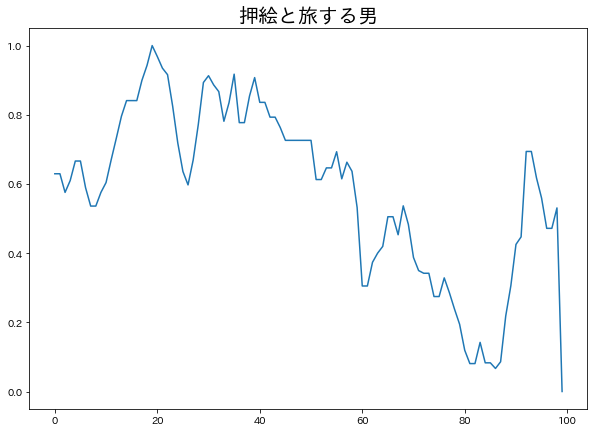

In [60]:
plt.figure(figsize=(10, 7))
plt.title(df.iloc[TARGET_DIC['id']]['作品名'], fontsize=20)
plt.plot(logit_score_norm)